# Aprendizagem Automática Avançada - Assignment 8
# Cláudia Afonso nº 36273 & Rita Rodrigues nº 54859

### Problem 2

**Take the tutorial on explaining image classification with LIME**

In [26]:
from shap import TreeExplainer
import shap
from lime.lime_tabular import LimeTabularExplainer
from lime import lime_image

In [27]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,DirectoryIterator
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras import backend as K
import os
import tensorflow as tf
from tensorflow.keras.applications import inception_v3 as inc_net

In [28]:
# Path to train and test directory
dir_ = "animals"


# Generate training and test data with Image Generator
train_datagen = ImageDataGenerator(rescale=1/255,
                                  validation_split = 0.2)


train_generator = train_datagen.flow_from_directory(dir_,target_size=(100, 100),
                                                   batch_size= 1920,
                                                   class_mode='categorical',
                                                   shuffle=False,
                                                   subset = 'training')

test_generator = train_datagen.flow_from_directory(dir_,
                                                          target_size = (100,100),
                                                          batch_size = 480,
                                                          class_mode = 'categorical',
                                                          shuffle=False,
                                                          subset = 'validation')


# Fetch the data and the labels
x_train, y_train = next(train_generator)
x_test, y_test  = next(test_generator)

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [29]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1920, 100, 100, 3), (1920, 3), (480, 100, 100, 3), (480, 3))

In [30]:
model = Sequential([
    
    # First convolution
        Conv2D(16, (3,3), activation='relu', input_shape=(100, 100, 3)),
        MaxPooling2D(2, 2),
    
    # Second convolution
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(2,2),
    
    # Third convolution
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
    
        Flatten(),
    
    # Dense hidden layer
        Dense(512, activation='relu'),
        Dropout(0.2),
    
    # Output neuron. 
        Dense(3, activation='softmax') 
])

In [31]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
      train_generator,  
      epochs=80,
      verbose=1)

Epoch 1/80
2/2 [==============================] - 13s 2s/step - loss: 1.7753 - accuracy: 0.3129
Epoch 2/80
2/2 [==============================] - 11s 2s/step - loss: 1.0047 - accuracy: 0.5425
Epoch 3/80
2/2 [==============================] - 10s 1s/step - loss: 1.1034 - accuracy: 0.3333
Epoch 4/80
2/2 [==============================] - 10s 1s/step - loss: 1.1192 - accuracy: 0.3333
Epoch 5/80
2/2 [==============================] - 11s 2s/step - loss: 1.1460 - accuracy: 0.3333
Epoch 6/80
2/2 [==============================] - 12s 2s/step - loss: 1.1754 - accuracy: 0.3333
Epoch 7/80
2/2 [==============================] - 14s 10s/step - loss: 1.3085 - accuracy: 0.3333
Epoch 8/80
2/2 [==============================] - 12s 2s/step - loss: 1.2730 - accuracy: 0.3333
Epoch 9/80
2/2 [==============================] - 12s 2s/step - loss: 1.1567 - accuracy: 0.3333
Epoch 10/80
2/2 [==============================] - 14s 10s/step - loss: 1.1077 - accuracy: 0.3333
Epoch 11/80
2/2 [====================

In [32]:
import numpy as np
import skimage

After reading and transforming the input image, we can use our custom model to predict our input image.

In [33]:
from skimage import io
from tensorflow.keras.preprocessing import image

url = 'https://raw.githubusercontent.com/marcellusruben/All_things_medium/main/Lime/panda_00024.jpg'

def read_and_transform_img(url):

    img = skimage.io.imread(url)
    img = skimage.transform.resize(img, (100,100))
    
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    return img

images = read_and_transform_img(url)

preds = model.predict(images)
prediction = np.argmax(preds)
pct = np.max(preds)

if prediction == 0:
    print('It\'s a cat!')
elif prediction == 1:
    print('It\'s a dog!')
else:
    print('It\'s a panda!')

print(pct)

1/1 [==============================] - 0s 134ms/step
It's a panda!
0.9021999


Our custom model correctly predicts that the animal in the image is a panda with reasonable certainty, i.e with 90.2% probability.

In [34]:
explainer = lime_image.LimeImageExplainer()

In [35]:
explanation = explainer.explain_instance(images[0].astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


(-0.5, 99.5, 99.5, -0.5)

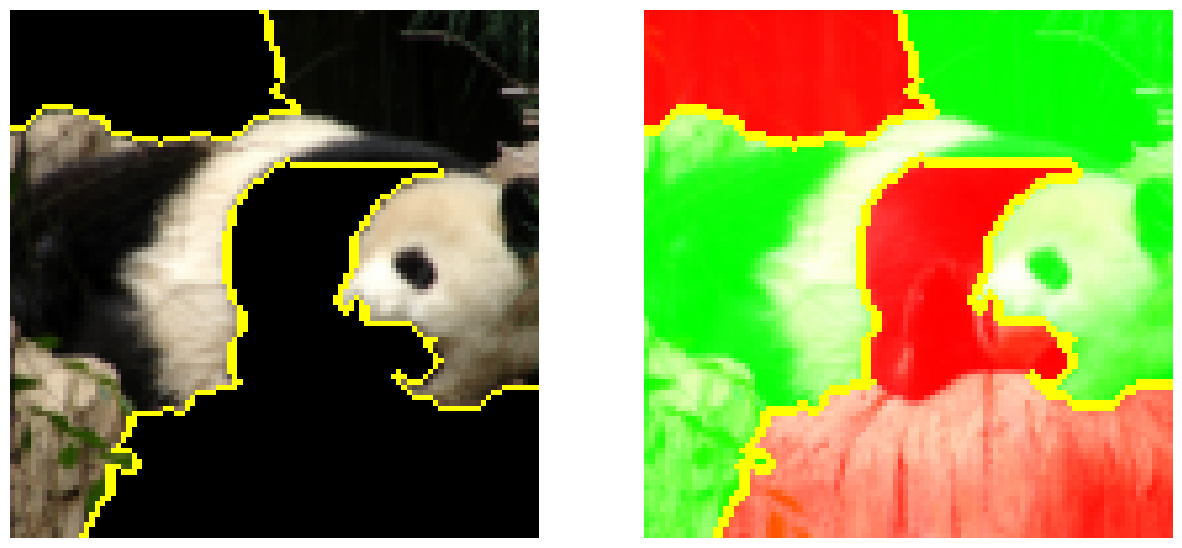

In [36]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

Now it is possible to understand why our model classifies our image as a panda. On the left image, we can see that only the super-pixels where the panda is visible are shown. This means that our model classifies our image as a panda because of these parts of super-pixels.

On the right image, the area of super-pixels colored in green are the ones that increase the probability of our image belonging to a panda class, while the super-pixels colored in red are the ones that decrease the probability.

In [37]:
from tensorflow.keras.applications.imagenet_utils import decode_predictions

def transform_img_fn_ori(url):
    
    img = skimage.io.imread(url)
    img = skimage.transform.resize(img, (299,299))
    img = (img - 0.5)*2
    img = np.expand_dims(img, axis=0)
    preds = inet_model.predict(img)
    for i in decode_predictions(preds)[0]:
        print(i)
    return img

inet_model = inc_net.InceptionV3()
images_inc_im = transform_img_fn_ori(url)

1/1 [==============================] - 1s 1s/step
('n02510455', 'giant_panda', 0.9290503)
('n04266014', 'space_shuttle', 0.0027943582)
('n04254680', 'soccer_ball', 0.0008264421)
('n02002556', 'white_stork', 0.00062917895)
('n02509815', 'lesser_panda', 0.0005990833)


As we can see, the pre-trained InceptionV3 model also predicts that our image is a panda. A giant panda to be precise.

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 715ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 298.5, 298.5, -0.5)

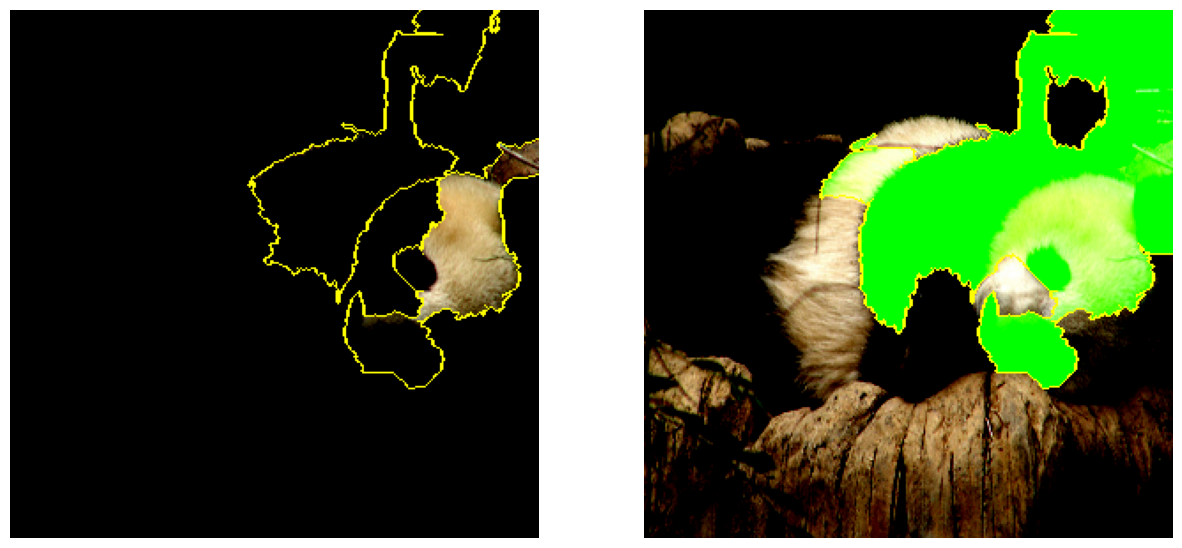

In [38]:
explanation= explainer.explain_instance(images_inc_im[0].astype('double'), inet_model.predict,  top_labels=3, hide_color=0, num_samples=1000)
 
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

The pre-trained model InceptionV3 model is able to classify our image as a panda due to the specific features of a panda.

**i) Use SHAP to obtain similar explanations to the ones you just obtained with LIME.**

In [40]:
#https://github.com/fau-masters-collected-works-cgarbin/shap-experiments-image-classification/blob/master/shap-experiments-image-classification.ipynb

# select backgroud for shap
background = x_train[np.random.choice(x_train.shape[0], 50, replace=False)]
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(model, background)

shap_values = explainer.shap_values(background)

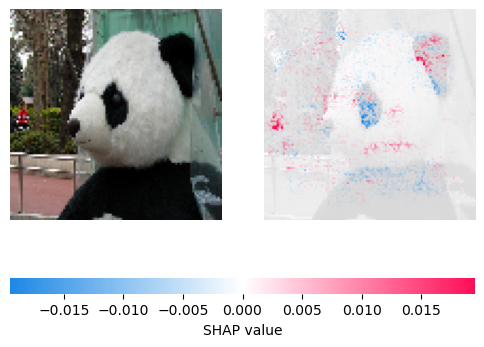

In [45]:
# Create a plot of the pixels that most contribute to the chosen class
shap.image_plot(shap_values[0][0], background[0], show=False)
plt.show()

**ii) Which approach generated better explanations?**

**LIME Plot:**
* This plot was generated using the Local Interpretable Model-agnostic Explanations (LIME) method. LIME works by approximating the decision boundary of a machine learning model in the vicinity of a specific input image, using a simpler and more interpretable model. In this case, the LIME explanation shows the most important pixels in the input image that contributed to the model's classification of the image as a panda.
* The LIME plot is generated using the get_image_and_mask method of the LIME explainer. Two plots are generated side by side - the left plot shows only the pixels that positively contributed to the classification, while the right plot shows both positive and negative pixel contributions. The pixels are highlighted using a boundary detection algorithm, which makes it easier to see which pixels are most important.
* The LIME plot shows the most important features for the top predicted class, with different colors indicating positive or negative impact on the prediction.
* The main advantage of LIME is its ability to provide local explanations for individual predictions, which can help to build trust in the model's decisions. Additionally, LIME is model-agnostic, meaning it can be used with any machine learning model. However, LIME has a few disadvantages as well. One disadvantage is that it requires sampling from the input space to generate explanations, which can be computationally expensive for high-dimensional inputs like images. Additionally, LIME only provides local explanations, so it can be difficult to understand how the model behaves globally.

**SHAP Plot:**
* This plot was generated using the SHapley Additive exPlanations (SHAP) method. SHAP works by assigning an importance value to each feature in the input image, based on how much each feature contributes to the model's output for that image. In this case, the SHAP plot shows the pixels in the input image that have the highest absolute SHAP values for the chosen class (panda).
* The SHAP plot is generated using the shap.image_plot function, which displays a grid of images, where each image shows the importance values for a single input image. In this case, we decided to only use the first image, which contains the example of a panda.
* The SHAP plot shows the most important pixels for the chosen class, with blue indicating negative impact and red indicating positive impact.
*  The main advantage of SHAP is that it provides a global explanation of the model's behavior, which can help to build trust in the model's overall performance. However, SHAP has some disadvantages as well. One disadvantage is that it requires computing the SHAP values for each input image separately, which can be computationally expensive for large datasets. Additionally, the SHAP values can be difficult to interpret, especially for non-experts, since they represent abstract quantities that are not directly related to the input image.


**Conclusion:**
* Based on the analysis of the LIME and SHAP plots, it appears that the LIME plot generated better explanations than the SHAP plot for the given task of explaining image classification for a panda. The LIME plot was able to provide a more intuitive and localized explanation of the model's decision by highlighting the specific pixels in the input image that contributed to the classification. Importantly, the number of super-pixels in green (the ones that increase the probability of an image belonging to a certain animal class, in this case a panda) in the LIME plot is much higher than the number of red dots (the ones that positively contribute to classify an image as belonging to a particular class, in this case a panda) appearing in the SHAP plot. In contrast, the SHAP plot provided a global explanation of the model's behavior, but the SHAP values can be difficult to interpret.